##SUPER RESOLUTION USING GANS

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
import cv2
import os
import zipfile

##EXTRACTING AND CREATING HIGH AND LOW RESOLUTION DATA

In [6]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Nagasaki_summer_internship/SR.zip")
zip_ref.extractall()
zip_ref.close()

In [7]:
for dirnames,dirpath,filenames in os.walk("dataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 7 directories and 0 images in '['Raw Data', 'val', 'train']'.
There are 16 directories and 0 images in '['high_res', 'low_res']'.
There are 25 directories and 855 images in '[]'.
There are 24 directories and 855 images in '[]'.
There are 11 directories and 0 images in '['high_res', 'low_res']'.
There are 20 directories and 170 images in '[]'.
There are 19 directories and 170 images in '[]'.
There are 13 directories and 0 images in '['high_res', 'low_res']'.
There are 22 directories and 685 images in '[]'.
There are 21 directories and 685 images in '[]'.


(-0.5, 255.5, 255.5, -0.5)

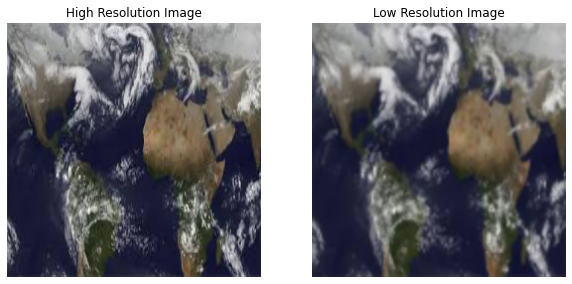

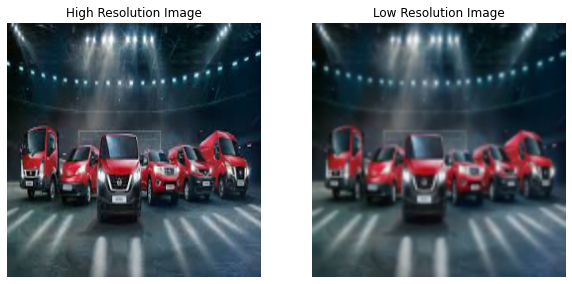

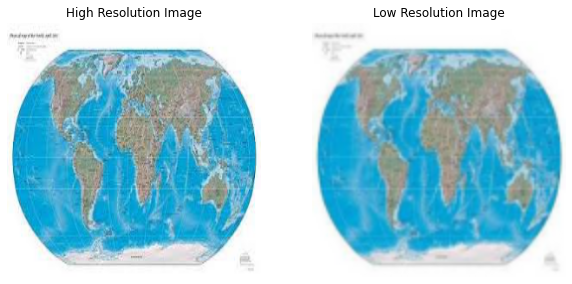

In [9]:
import matplotlib.image as mping
img_1 = mping.imread("/content/dataset/train/high_res/1.png")
img_2 = mping.imread("/content/dataset/train/low_res/1.png")
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img_1)
plt.title("High Resolution Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_2)
plt.title("Low Resolution Image")
plt.axis("off")
img_3 = mping.imread("/content/dataset/train/high_res/20.png")
img_4 = mping.imread("/content/dataset/train/low_res/20.png")
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img_3)
plt.title("High Resolution Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_4)
plt.title("Low Resolution Image")
plt.axis("off")
img_5 = mping.imread("/content/dataset/train/high_res/100.png")
img_6 = mping.imread("/content/dataset/train/low_res/100.png")
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img_5)
plt.title("High Resolution Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_6)
plt.title("Low Resolution Image")
plt.axis("off")

In [10]:
from keras.preprocessing.image import img_to_array
import re
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
path = '/content/dataset/Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))


low_img = []
path = '/content/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '855.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|██████████| 855/855 [00:02<00:00, 314.27it/s]


In [11]:
train_high_res = high_img[:700]
train_low_res = low_img[:700]
train_high_res = np.reshape(train_high_res,(len(train_high_res),SIZE,SIZE,3))
train_low_res = np.reshape(train_low_res,(len(train_low_res),SIZE,SIZE,3))

test_high_res = high_img[700:]
test_low_res = low_img[700:]
test_high_res= np.reshape(test_high_res,(len(test_high_res),SIZE,SIZE,3))
test_low_res = np.reshape(test_low_res,(len(test_low_res),SIZE,SIZE,3))

print("Shape of training images:",train_high_res.shape)
print("Shape of test images:",test_high_res.shape)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (155, 256, 256, 3)


##MODELLING

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras

def down_sample_layer(filters,kernel_size,batch_norm = True):
   downsample = tf.keras.models.Sequential()
   downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
   if batch_norm:
     downsample.add(layers.BatchNormalization())
     downsample.add(keras.layers.LeakyReLU())
   return downsample

In [ ]:
def up_sample_layer(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.3)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [ ]:
def super_res_model():
  inputs = layers.Input(shape= [256,256,3]) 
  #Downsampling
  d1 = down_sample_layer(128,(3,3),False)(inputs)
  d2 = down_sample_layer(128,(3,3),False)(d1)
  d3 = down_sample_layer(256,(3,3),True)(d2)
  d4 = down_sample_layer(512,(3,3),True)(d3)
  d5 = down_sample_layer(512,(3,3),True)(d4)
  #Upsampling
  u1 = up_sample_layer(512,(3,3),False)(d5)
  u1 = layers.concatenate([u1,d4])
  u2 = up_sample_layer(256,(3,3),False)(u1)
  u2 = layers.concatenate([u2,d3])
  u3 = up_sample_layer(128,(3,3),False)(u2)
  u3 = layers.concatenate([u3,d2])
  u4 = up_sample_layer(128,(3,3),False)(u3)
  u4 = layers.concatenate([u4,d1])
  u5 = up_sample_layer(3,(3,3),False)(u4)
  u5 = layers.concatenate([u5,inputs])
  output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
  return tf.keras.Model(inputs=inputs, outputs=output)

   

In [ ]:
model_1 = super_res_model()
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  147584      ['sequential[0][0]']             
                                                                                              

In [ ]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',metrics = ['accuracy'])

In [ ]:
checkpoint_path = "Super_resolution_model_1/checkpoint.ckpt"
checkpoint_1 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_best_only=True,save_weights_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 5,min_delta = 0.0001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",patience =10,factor = 0.1,verbose =1,min_lr = 1e-7)

In [ ]:
history_1 = model_1.fit(train_low_res,train_high_res,epochs = 40,batch_size = 1,
            validation_data = (test_low_res,test_high_res),
            callbacks = [early_stop,checkpoint_1])

Epoch 1/40
700/700 [==============================] - 30s 23ms/step - loss: 0.0529 - accuracy: 0.6336 - val_loss: 0.0280 - val_accuracy: 0.7568
Epoch 2/40
700/700 [==============================] - 16s 23ms/step - loss: 0.0262 - accuracy: 0.7772 - val_loss: 0.0266 - val_accuracy: 0.8407
Epoch 3/40
700/700 [==============================] - 16s 23ms/step - loss: 0.0230 - accuracy: 0.8120 - val_loss: 0.0212 - val_accuracy: 0.8196
Epoch 4/40
700/700 [==============================] - 16s 23ms/step - loss: 0.0218 - accuracy: 0.8031 - val_loss: 0.0204 - val_accuracy: 0.8280
Epoch 5/40
700/700 [==============================] - 17s 24ms/step - loss: 0.0210 - accuracy: 0.8209 - val_loss: 0.0196 - val_accuracy: 0.8429
Epoch 6/40
700/700 [==============================] - 17s 24ms/step - loss: 0.0208 - accuracy: 0.8207 - val_loss: 0.0209 - val_accuracy: 0.8732
Epoch 7/40
700/700 [==============================] - 17s 24ms/step - loss: 0.0196 - accuracy: 0.8324 - val_loss: 0.0223 - val_accuracy:

In [ ]:
model_1.save("Super_resolution_model_1.h5")

##MODEL EVALUATION

In [ ]:
model_1.evaluate(test_low_res,test_high_res)

5/5 [==============================] - 4s 483ms/step - loss: 0.0173 - accuracy: 0.8986


[0.017327746376395226, 0.8985665440559387]

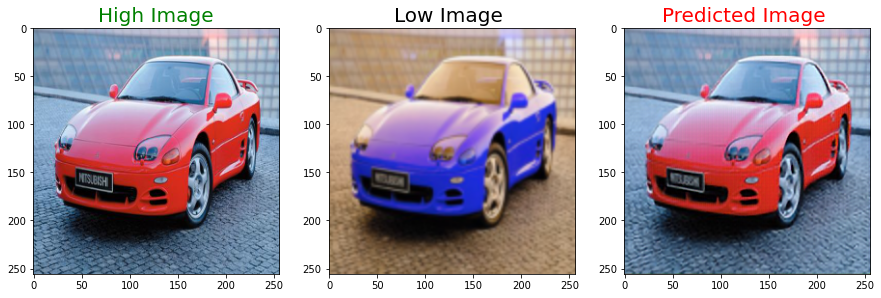

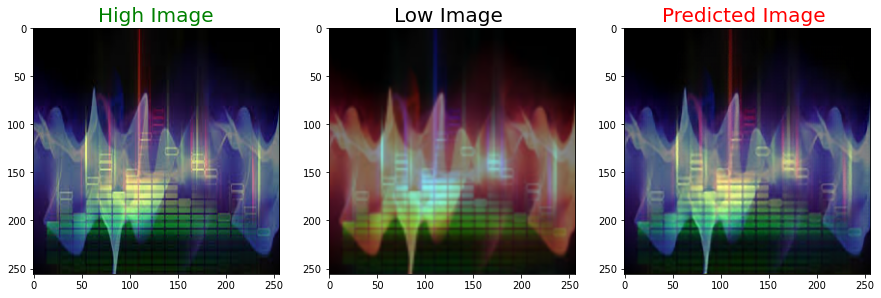

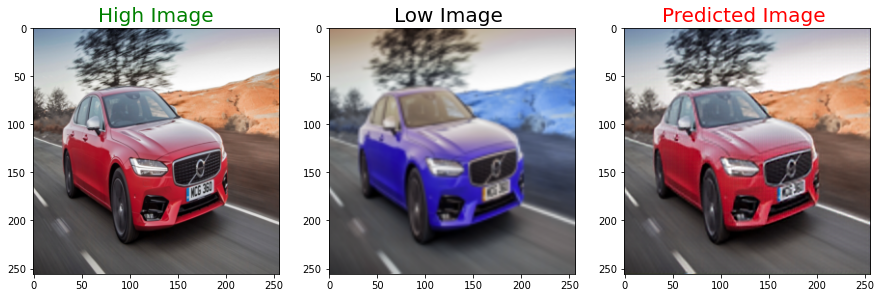

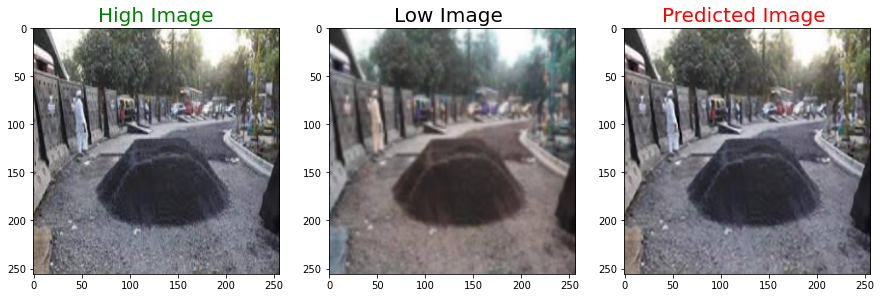

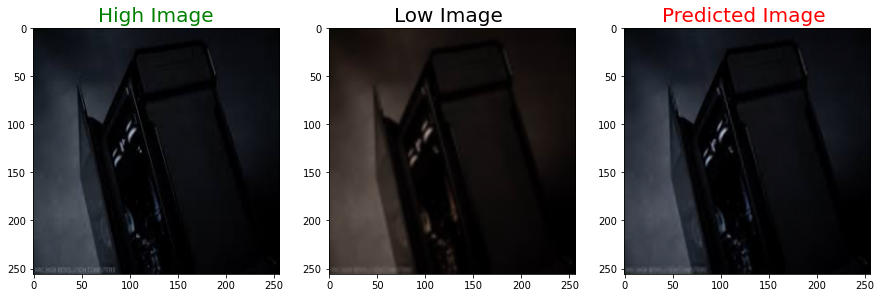

In [ ]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(1,6):
    
    predicted = np.clip(model_1.predict(test_low_res[i].reshape(1,256, 256,3)),0.0,1.0).reshape(256, 256,3)
    plot_images(test_high_res[i],test_low_res[i],predicted)

##SRGAN